In [1]:
%matplotlib inline
import mglearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_breast_cancer

c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Uncertainty Estimates from Classifiers

`scikit-learn` also provides the ability for classifiers to give uncertainty estimates on predictions.  `scikit-learn` has two functions, `decision_function` and `predict_proba` that give estimates of the uncertainty.  Most classifiers have at least one of these functions and many even have both.  `GradientBoostingClassifier` is one of the models that has both so we will use this to test them on a fake sample dataset.

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)
# we rename the classes "blue" and "red" for illustration purposes
y_named = np.array(["blue", "red"])[y]
# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
 train_test_split(X, y_named, y, random_state=0)
# build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Decision Function

For the case of binary classifications, `decision_function` returns a value of shape `(n_samples,)`. One floating point number per sample. The value encodes how sure the model is of its prediction and the sign of the value gives us the actual classification (negative for Class 0 and positive for Class 1). For binary classification, the “negative” class is always the first entry of the `classes_` attribute, and the “positive” class is the second entry of `classes_`. So if you want to fully recover the output of predict, you need to make use of the `classes_` attribute.

In [4]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

# show the first few entries of decision_function
print("\nDecision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

print("\nThresholded decision function:\n{}".format(gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

X_test.shape: (25, 2)
Decision function shape: (25,)

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [6]:
# make the boolean True/False into 0 and 1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# use 0 and 1 as indices into classes_
pred = gbrt.classes_[greater_zero]
# pred is the same as the output of gbrt.predict
print("pred is equal to predictions: {}".format(np.all(pred == gbrt.predict(X_test))))

decision_function = gbrt.decision_function(X_test)
print("\nDecision function minimum: {:.2f} maximum: {:.2f}".format(np.min(decision_function), np.max(decision_function)))


pred is equal to predictions: True

Decision function minimum: -7.69 maximum: 4.29


The range of the `decision_function` is arbitrary and depends on the parameters of the model and the data itself.  The arbitrary scaling often makes the output of the decision function hard to interpret.  The following plot shows the decision boundary (left) vs the decision function (right).

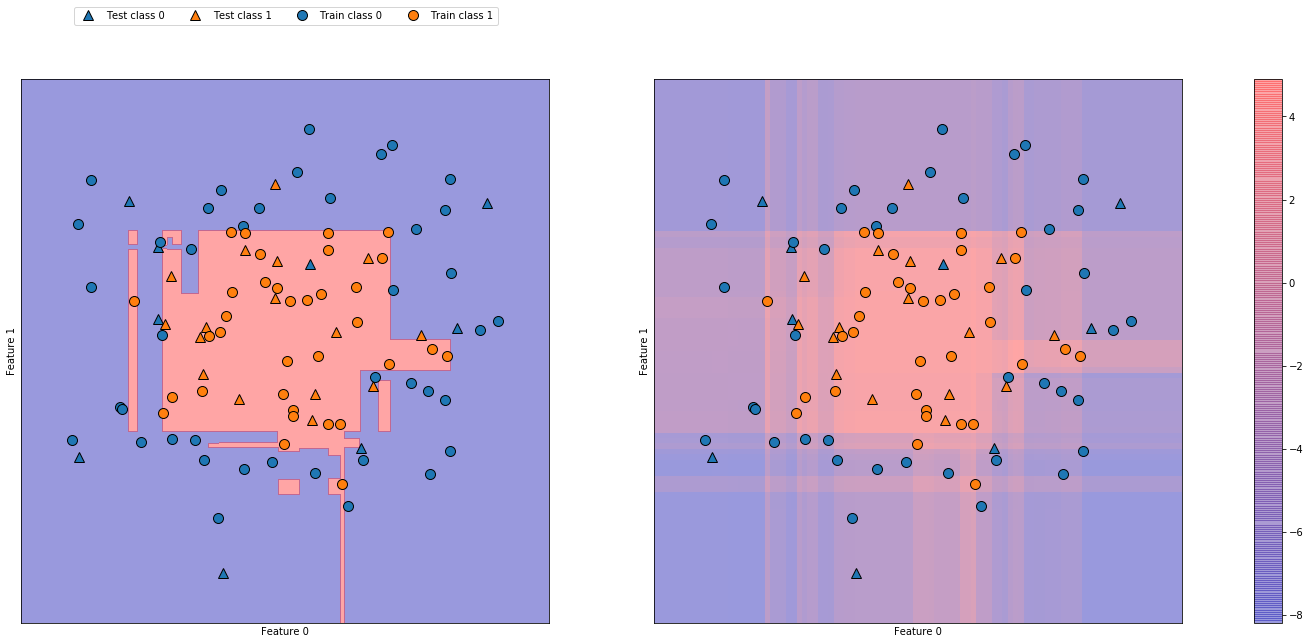

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(26, 10))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
    markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
    markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))

This additional info is often very helpful, however it is hard to gain any more info from this specific visualization.

### Predicting Probabilities

The `predict_proba` function reports a probability for each class.  Because it reports probabilities it is often much easier to understand than the `decision_function`.  For binary classification the shape is always `(n_samples,2)`.

In [10]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

# show the first few entries of predict_proba
print("\nPredicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

Shape of probabilities: (25, 2)

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


The first entry in the row is the prediction for the first class, and the second is for second class.  Because these are probabilities the row must always sum up to 1 and the values will always be between 0 and 1.  For this binary classification, the class that has the probability above 50% will be the one predicted.

__*Note*__: Because the probabilities are floating-point numbers, it is unlikely that they will both be exactly 0.500. However, if that happens, the prediction is made at random.

You can see in the previous output that the classifier is relatively certain for most points. How well the uncertainty actually reflects uncertainty in the data depends on the model and the parameters. A model that is more overfitted tends to make more certain predictions, even if they might be wrong. A model with less complexity usu‐ ally has more uncertainty in its predictions. A model is called __calibrated__ if the reported uncertainty actually matches how correct it is — in a calibrated model, a prediction made with 70% certainty would be correct 70% of the time.

In the example we again show the decision boundary on the dataset next to the class probabilities for the class 1:

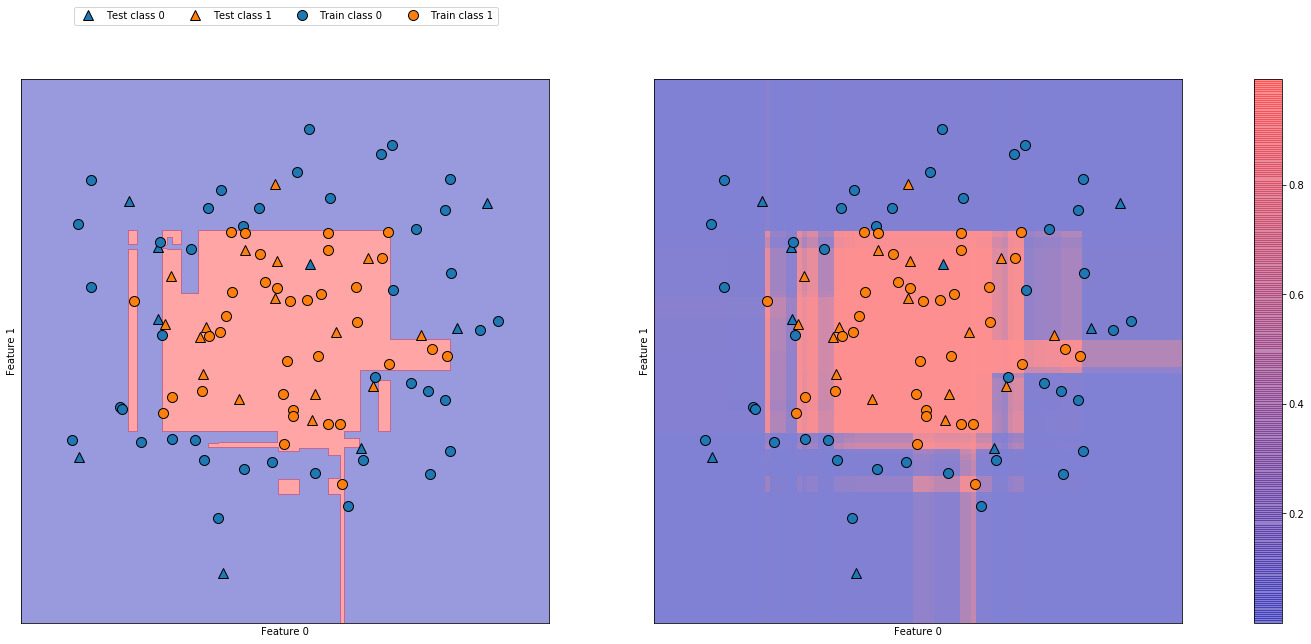

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(26, 10))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
    markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
    markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))

This plot's boundaries are much more well defined and the regions of uncertainty are clear.  The [`scikit-learn` website](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) has great comparisons of models and their uncertainty estimators look like.

### Uncertainty in Multiclass Classifications

So far the discussion has been limited to binary classifications but these methods also work for multiclass problems.  Here we will apply them to the thre-class iris flower dataset.

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# plot the first few entries of the decision function
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function:
[[-1.9957153   0.04758118 -1.92721297]
 [ 0.0614655  -1.90755689 -1.92793177]
 [-1.99058105 -1.87637856  0.09686741]
 [-1.9957153   0.04758118 -1.92721297]
 [-1.99730166 -0.13469231 -1.20341532]
 [ 0.0614655  -1.90755689 -1.92793177]]


In the multiclass case, the decision_function has the shape `(n_samples, n_classes)` and each column provides a “certainty score” for each class, where a large score means that a class is more likely and a small score means the class is less likely. You can recover the predictions from these scores by finding the maximum entry for each data point.

In [14]:
print("Argmax of decision function:\n{}".format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


`predict_proba` has the same shape, and again the rows of probabilities will sum to 1.  We can again get the prediction using the `argmax` function.

In [16]:
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# show that sums across rows are one
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

print("\nArgmax of predicted probabilities:\n{}".format(
 np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Predicted probabilities:
[[0.10217734 0.78840063 0.10942203]
 [0.7834712  0.1093673  0.1071615 ]
 [0.09818079 0.11005862 0.79176059]
 [0.10217734 0.78840063 0.10942203]
 [0.10360014 0.66723882 0.22916105]
 [0.7834712  0.1093673  0.1071615 ]]
Sums: [1. 1. 1. 1. 1. 1.]

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


`predict_proba` and `decision_function` will always have the same shape except for the special binary case, where the decision function has only one column corresponding to the positive class (`classes_[1]`). This is mostly for historical reasons.

You can recover the prediction when there are n_classes many columns by computing the argmax across columns. Be careful, though, if your classes are strings, or you use integers but they are not consecutive and starting from 0. If you want to compare results obtained with predict to results obtained via `decision_function` or `predict_proba`, make sure to use the `classes_` attribute of the classifier to get the actual class names.

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# represent each target by its class name in the iris dataset
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format(logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# Summary and Outlook

A lot was covered in chapter 2.  Here's a quick summary of all the models dicussed and when they should be applied.

_Nearest neighbors_
* For small datasets
* Good as a baseline
* Easy to explain

_Linear models_
* Go-to as a first algorithm to try
* Good for very large datasets
* Good for very highdimensional data

_Naive Bayes_
* Only for classification
* Even faster than linear models
* Good for very large datasets and high-dimensional data
* Often less accurate than linear models

_Decision trees_
* Very fast
* Don’t need scaling of the data
* Can be visualized and easily explained

_Random forests_
* Nearly always perform better than a single decision tree
* Very robust and powerful
* Don’t need scaling of data
* Not good for very high-dimensional sparse data

_Gradient boosted decision trees_
* Often slightly more accurate than random forests
* Slower to train but faster to predict than random forests and smaller in memory
* Need more parameter tuning than random forests

_Support vector machines_
* Powerful for medium-sized datasets of features with similar meaning
* Require scaling of data
* Sensitive to parameters

_Neural networks_
* Can build very complex models, particularly for large datasets
* Sensitive to scaling of the data and to the choice of parameters
* Large models need a long time to train

When working with a new dataset, it is in general a good idea to start with a simple model, such as a linear model or a naive Bayes or nearest neighbors classifier, and see how far you can get. After understanding more about the data, you can consider moving to an algorithm that can build more complex models, such as random forests, gradient boosted decision trees, SVMs, or neural networks.

After this chapter there is enough of a background to start applying, tuning, and analyzing models.